In [3]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [4]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [17]:
y=pd.read_csv("cardox.csv")
df=pd.DataFrame({"value":y["value"].values}, index=pd.to_datetime(y["date"]))
#df["date"]=pd.to_datetime(df["date"])
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [18]:
df.tail()

,value
date,
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51
2018-10-01,406.00
2018-11-01,408.02


[<Axes: >]

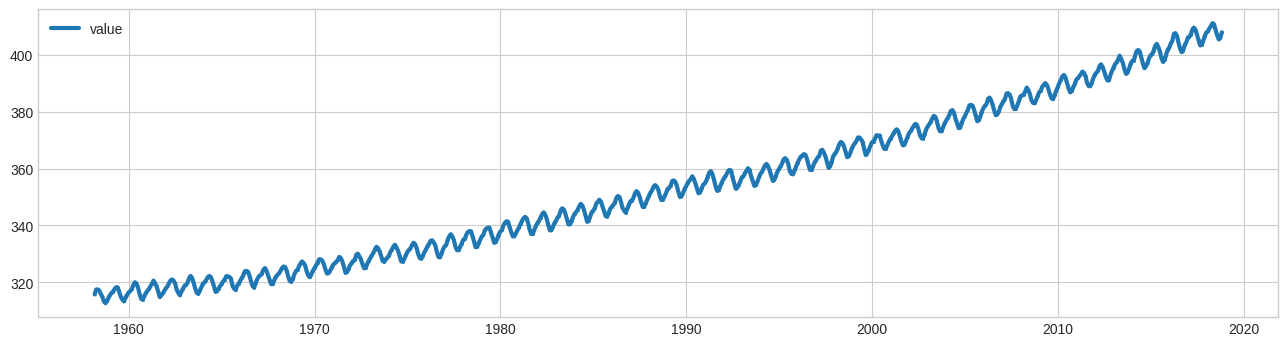

In [19]:
plot(df, ts_linewidth=3)

In [20]:
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


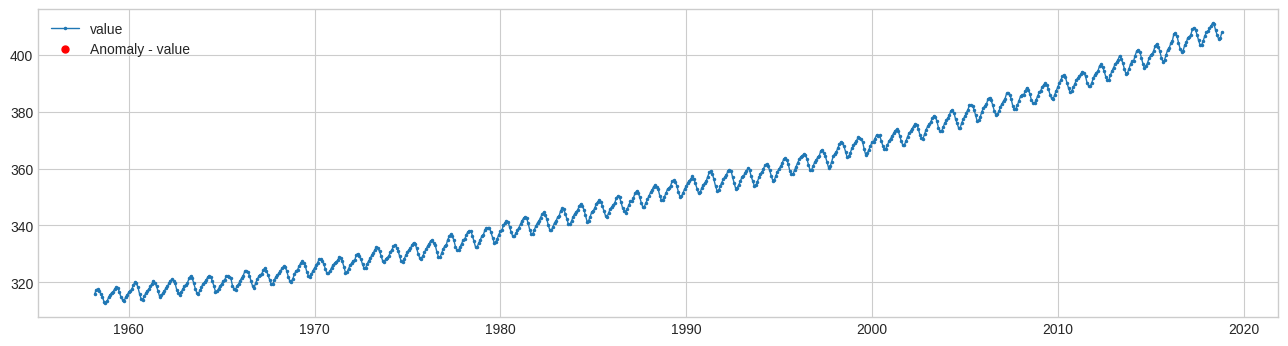

In [37]:
threshold_ad = ThresholdAD(high=412, low=312)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

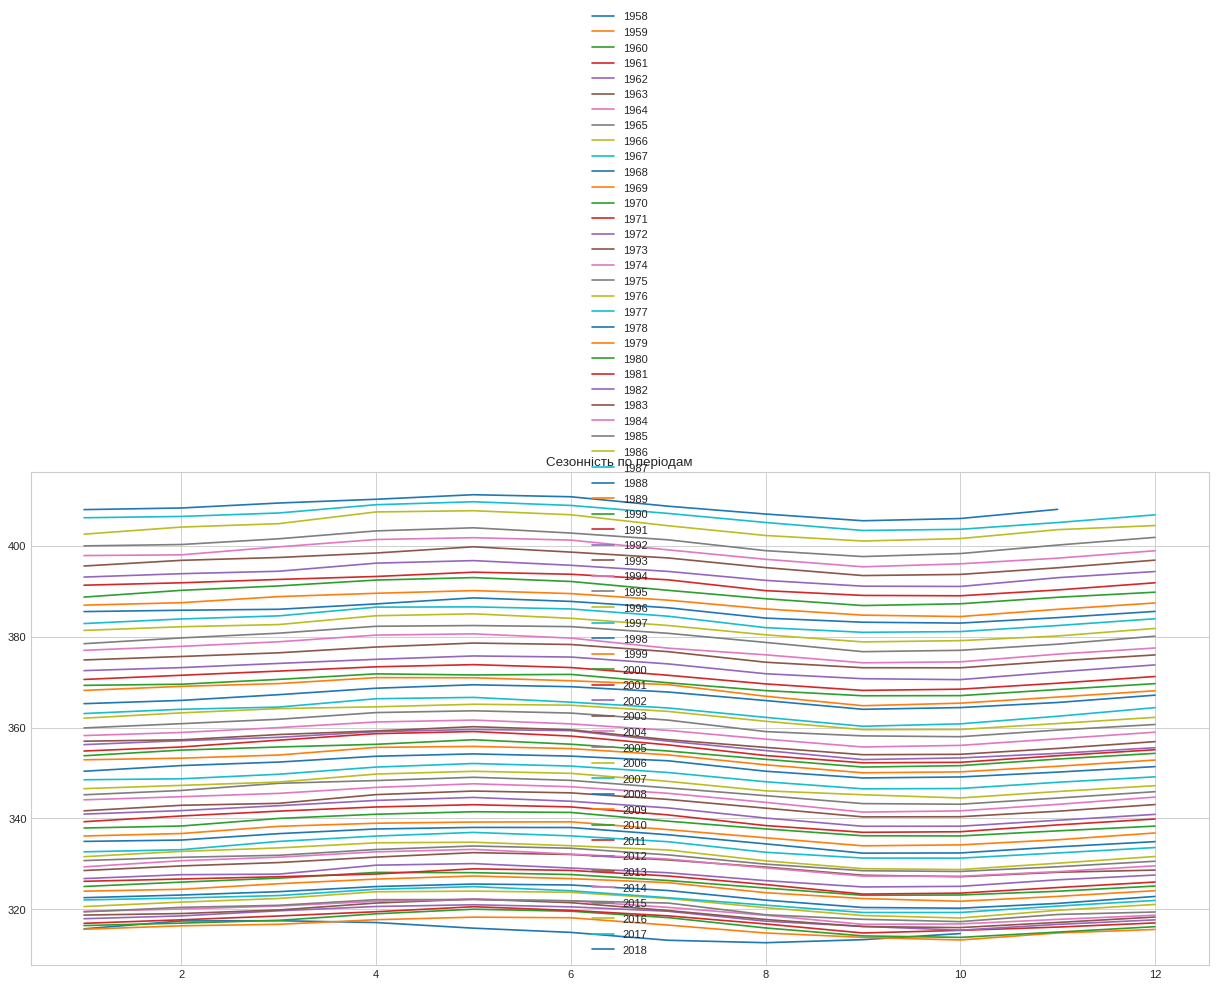

In [41]:
sesonal(df,12)

Text(0.5, 0.98, 'Мультиплікатива модель')

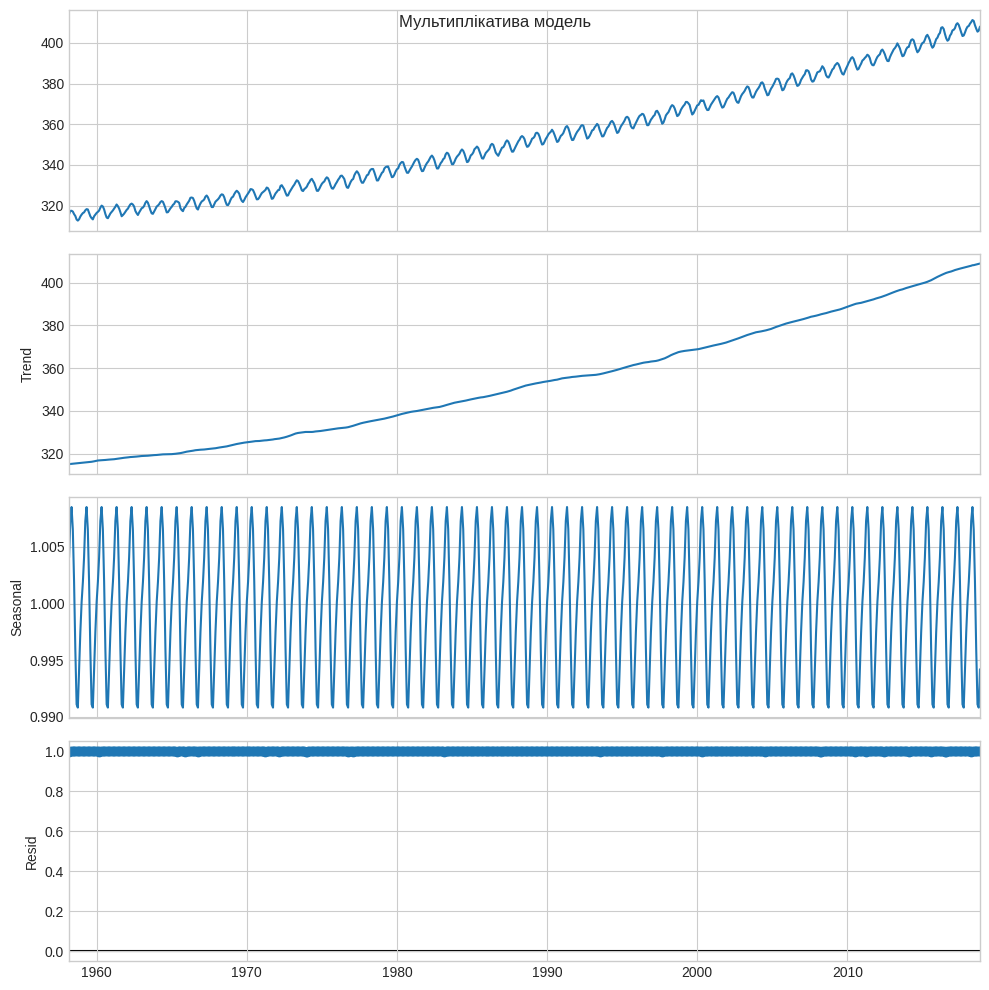

In [43]:
# декомпозиция 
result_M = seasonal_decompose(df, model='multiplicative', extrapolate_trend=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [44]:
result_M.seasonal['2011']

date
2011-01-01    1.000135
2011-02-01    1.001929
2011-03-01    1.004054
2011-04-01    1.007302
2011-05-01    1.008530
2011-06-01    1.006555
2011-07-01    1.001988
2011-08-01    0.995917
2011-09-01    0.991096
2011-10-01    0.990812
2011-11-01    0.994200
2011-12-01    0.997482
Name: seasonal, dtype: float64

In [45]:
result_M.trend['2011']

date
2011-01-01    390.768750
2011-02-01    390.939167
2011-03-01    391.106250
2011-04-01    391.272500
2011-05-01    391.412917
2011-06-01    391.566250
2011-07-01    391.727083
2011-08-01    391.885000
2011-09-01    392.043333
2011-10-01    392.240417
2011-11-01    392.468750
2011-12-01    392.657083
Name: trend, dtype: float64

Text(0.5, 0.98, 'Адитивная модель')

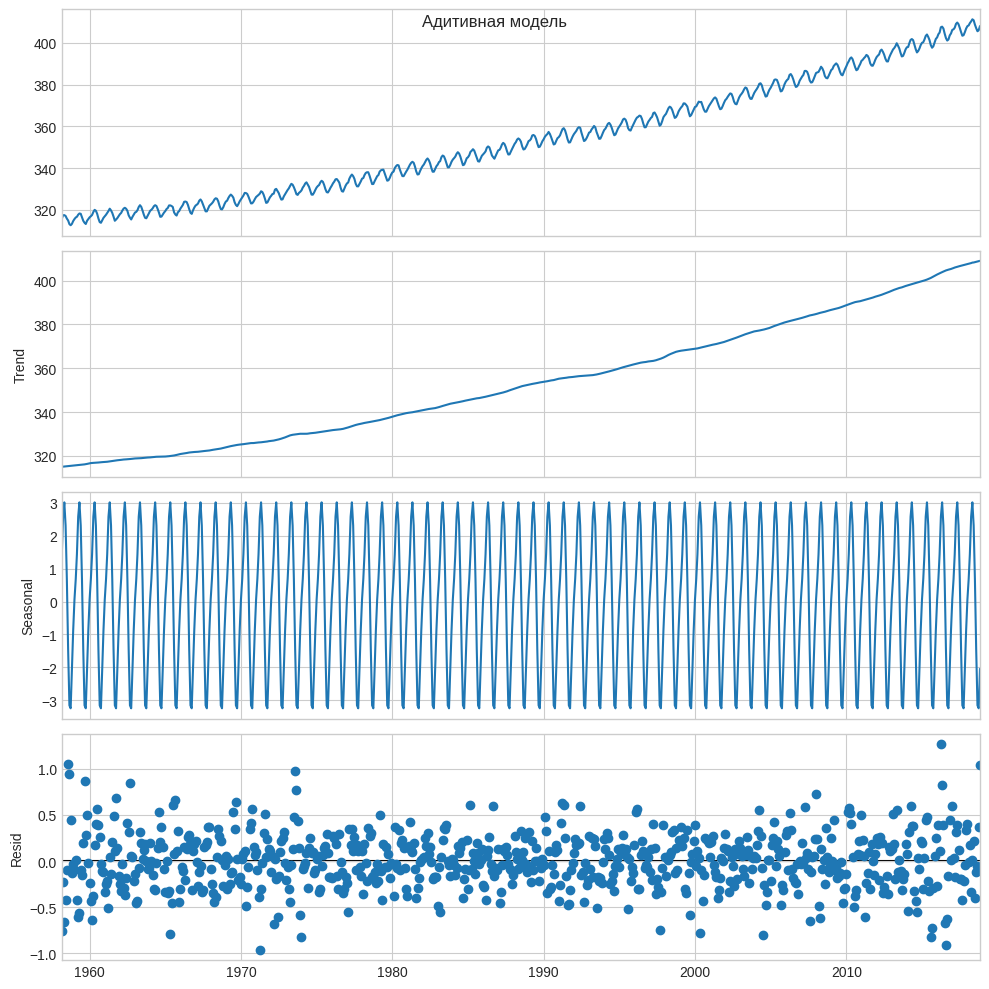

In [47]:
# Decompose 
result_A = seasonal_decompose(df, model='additive', extrapolate_trend=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

In [48]:
result_A.seasonal['2011']

date
2011-01-01    0.059289
2011-02-01    0.688213
2011-03-01    1.435042
2011-04-01    2.579879
2011-05-01    3.010959
2011-06-01    2.308198
2011-07-01    0.687431
2011-08-01   -1.456150
2011-09-01   -3.152087
2011-10-01   -3.241776
2011-11-01   -2.041328
2011-12-01   -0.877669
Name: seasonal, dtype: float64

In [49]:
result_A.trend['2011']

date
2011-01-01    390.768750
2011-02-01    390.939167
2011-03-01    391.106250
2011-04-01    391.272500
2011-05-01    391.412917
2011-06-01    391.566250
2011-07-01    391.727083
2011-08-01    391.885000
2011-09-01    392.043333
2011-10-01    392.240417
2011-11-01    392.468750
2011-12-01    392.657083
Name: trend, dtype: float64

In [51]:
train=df['2000':'2016']
train.head()

,value
date,
2000-01-01,369.29
2000-02-01,369.54
2000-03-01,370.60
2000-04-01,371.82
2000-05-01,371.58


Тестовые данные возьмем за 7 месяцев 2019 года. 

In [52]:
test=df['2017':'2018']
test.head()

,value
date,
2017-01-01,406.17
2017-02-01,406.46
2017-03-01,407.22
2017-04-01,409.04
2017-05-01,409.69


In [53]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [54]:
fit1.params

{'smoothing_level': 0.5432675980042282,
 'smoothing_trend': 7.861607358889163e-13,
 'smoothing_seasonal': 1.0427493356040986e-14,
 'damping_trend': nan,
 'initial_level': 369.92873602818963,
 'initial_trend': 0.18087487755302054,
 'initial_seasons': array([0.99716495, 0.99874306, 1.00057596, 1.00372623, 1.00469786,
        1.00251031, 0.99775374, 0.99193851, 0.98794302, 0.98792743,
        0.99129405, 0.99456362]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [55]:
fit1.fittedvalues

date
2000-01-01    369.060331
2000-02-01    369.950021
2000-03-01    370.586776
2000-04-01    371.942306
2000-05-01    372.417573
                 ...    
2016-08-01    402.553077
2016-09-01    400.957139
2016-10-01    401.179949
2016-11-01    402.949901
2016-12-01    404.785926
Length: 204, dtype: float64

In [56]:
fit1.forecast(12)

2017-01-01    405.842050
2017-02-01    406.664982
2017-03-01    407.592276
2017-04-01    409.057110
2017-05-01    409.634814
2017-06-01    408.924235
2017-07-01    407.164497
2017-08-01    404.970827
2017-09-01    403.518317
2017-10-01    403.690639
2017-11-01    405.245620
2017-12-01    406.762127
Freq: MS, dtype: float64

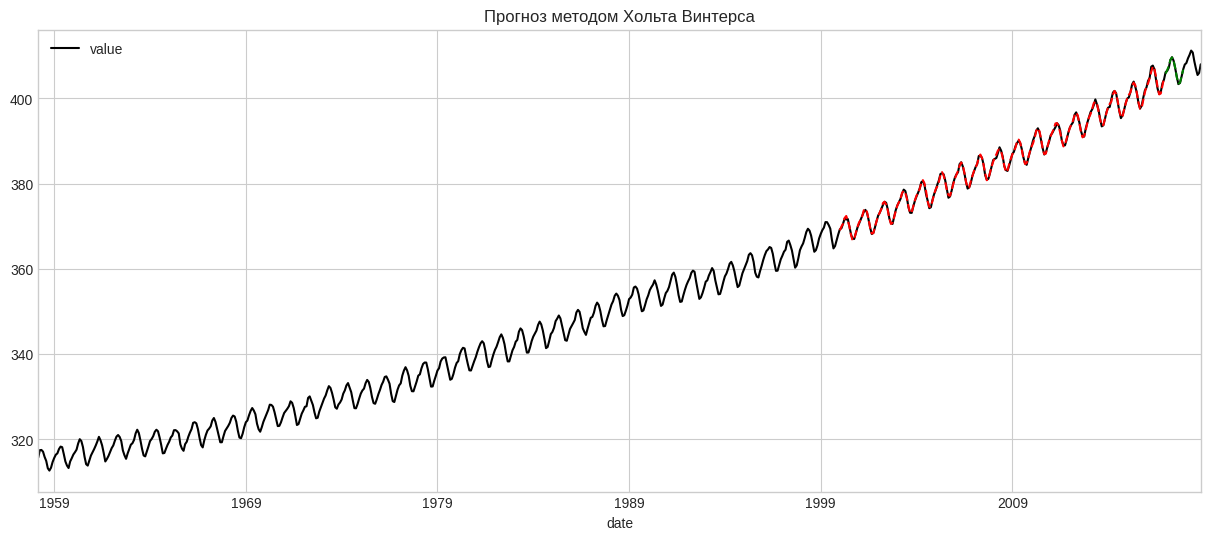

In [57]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [58]:
metrics(train, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -9.630
	P-значення = 0.000
Критичне значення :
	1%: -3.4633090972761744 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.876029332045744 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5744932593252643 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2348
MSE: 0.0932
MAPE: 0.0006
MPE: -0.0
Стандартна похибка: 0.3052


In [59]:
metrics(test, fit1.forecast(len(test)))

Тест на стаціонарність:
	T-статистика = -3.206
	P-значення = 0.020
Критичне значення :
	1%: -4.068853732362312 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.1271488757396453 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.7017297633136095 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2651
MSE: 0.1311
MAPE: 0.0006
MPE: -0.0004
Стандартна похибка: 0.362


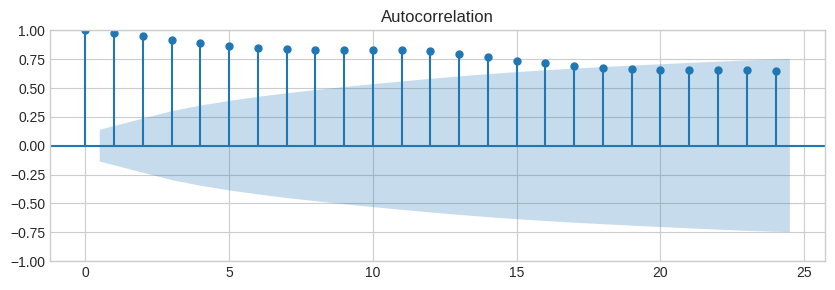

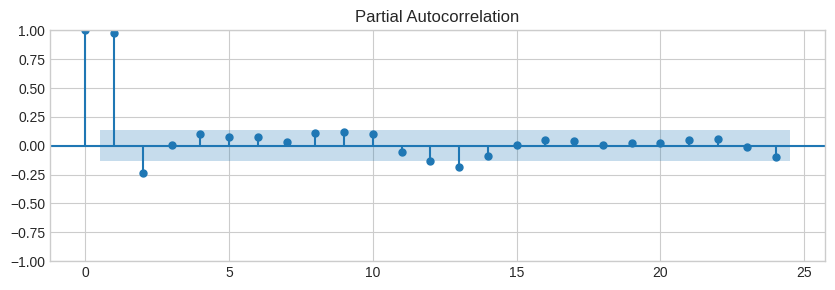

In [61]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train, lags=24)
plot_pacf(train, lags=24)
plt.show()

In [62]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=148.052, Time=3.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=238.105, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=175.119, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=145.724, Time=0.80 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=211.283, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=147.623, Time=1.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=147.632, Time=1.98 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=169.973, Time=0.54 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=149.532, Time=4.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=170.095, Time=0.60 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=144.351, Time=1.11 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=211.820, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=146.276, Time=1.53 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=146.278, Time=2.64 sec
 ARIMA(1,1,1)(1,1,0)[12]         

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [63]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12))

results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75409D-01    |proj g|=  7.39443D-01


 This problem is unconstrained.



At iterate    5    f=  3.41797D-01    |proj g|=  5.57383D-02

At iterate   10    f=  3.34207D-01    |proj g|=  3.37070D-03

At iterate   15    f=  3.34195D-01    |proj g|=  2.06510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   8.729D-06   3.342D-01
  F =  0.33419436708433986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3130      0.124      2.522      0.012       0.070       0.556


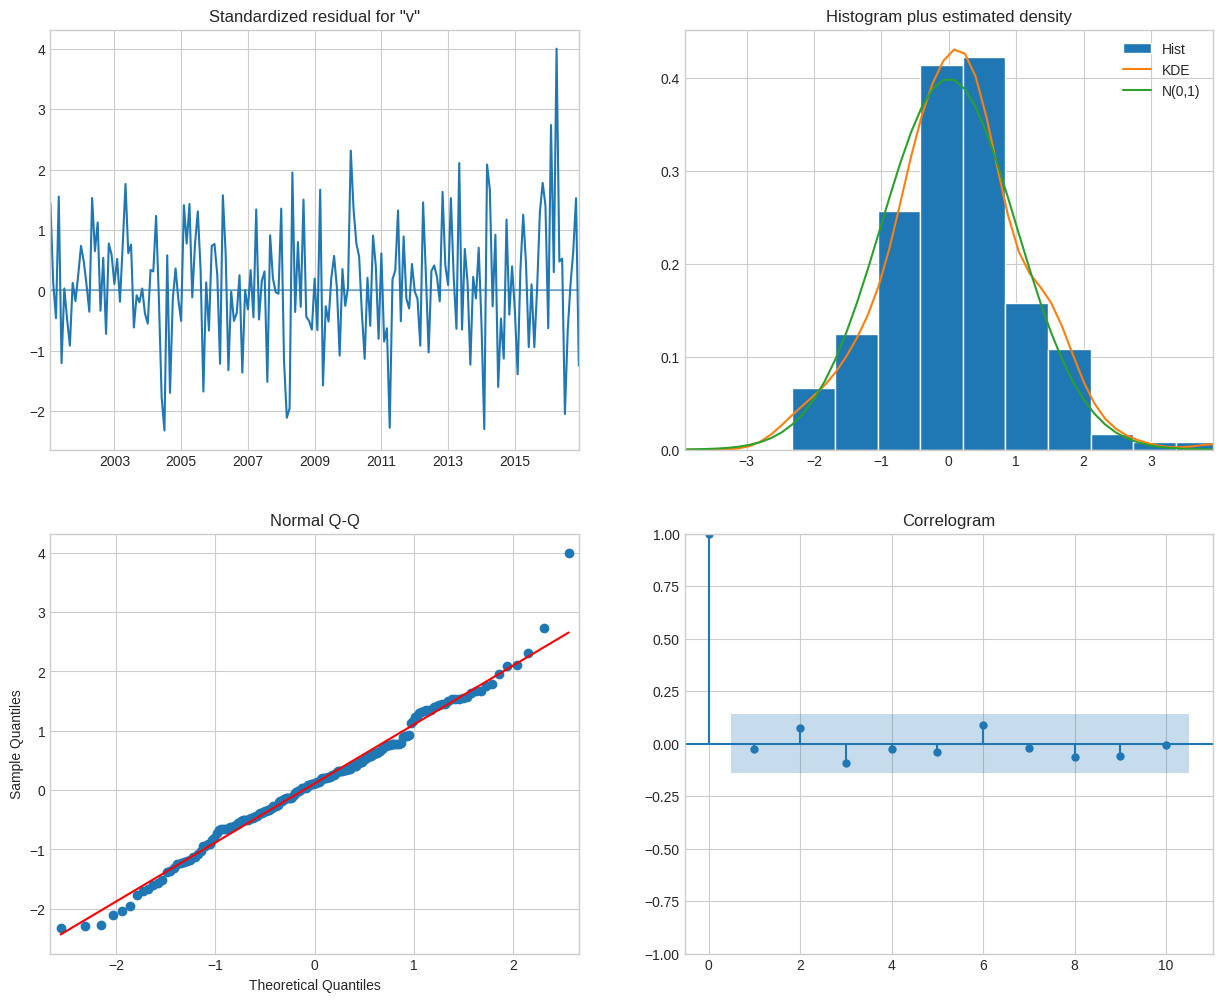

In [64]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [65]:
predict=results.get_prediction()
predict.predicted_mean[:10]

2000-01-01      0.000000
2000-02-01    369.289988
2000-03-01    369.539996
2000-04-01    370.599999
2000-05-01    371.820000
2000-06-01    371.580000
2000-07-01    371.700000
2000-08-01    369.860000
2000-09-01    368.130000
2000-10-01    367.000001
Freq: MS, Name: predicted_mean, dtype: float64

In [66]:
predict=results.get_prediction(start='2016-01-01')
metrics(train['2016-01-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -9.440
	P-значення = 0.000
Критичне значення :
	1%: -4.9386902332361515 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -3.477582857142857 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.8438679591836733 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.4159
MSE: 0.3125
MAPE: 0.001
MPE: 0.0004
Стандартна похибка: 0.559


In [67]:
predict=results.get_prediction(start='2018', end='2020')

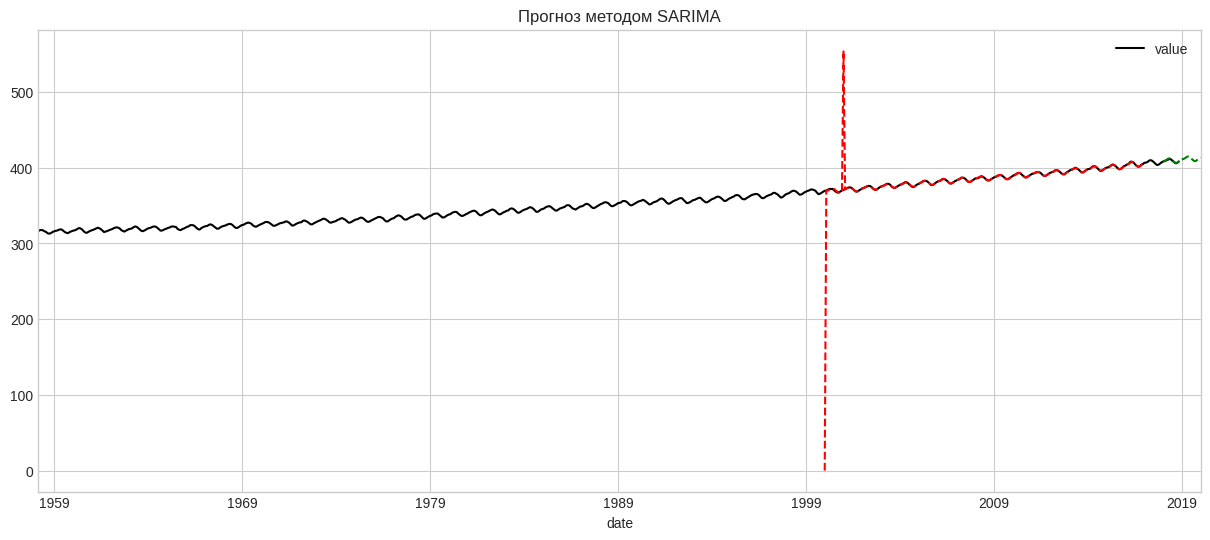

In [68]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [71]:
predict=results.get_prediction(start='2017-01-01', end='2018-06-01')
metrics(test[5:], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -3.249
	P-значення = 0.017
Критичне значення :
	1%: -4.331573 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.23295 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.7487 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 3.6345
MSE: 16.763
MAPE: 0.0089
MPE: -0.0012
Стандартна похибка: 4.0943


In [80]:
predict=results.get_prediction(start='2018-12-01', end='2048-12-01')

In [81]:
predict.predicted_mean

2018-12-01    409.380769
2019-01-01    410.496717
2019-02-01    411.335051
2019-03-01    412.296574
2019-04-01    413.932309
                 ...    
2048-08-01    479.708274
2048-09-01    478.335730
2048-10-01    478.672719
2048-11-01    480.284746
2048-12-01    481.697030
Freq: MS, Name: predicted_mean, Length: 361, dtype: float64

In [102]:
pred=predict.predicted_mean
type(pred)

pandas.core.series.Series

[<Axes: >]

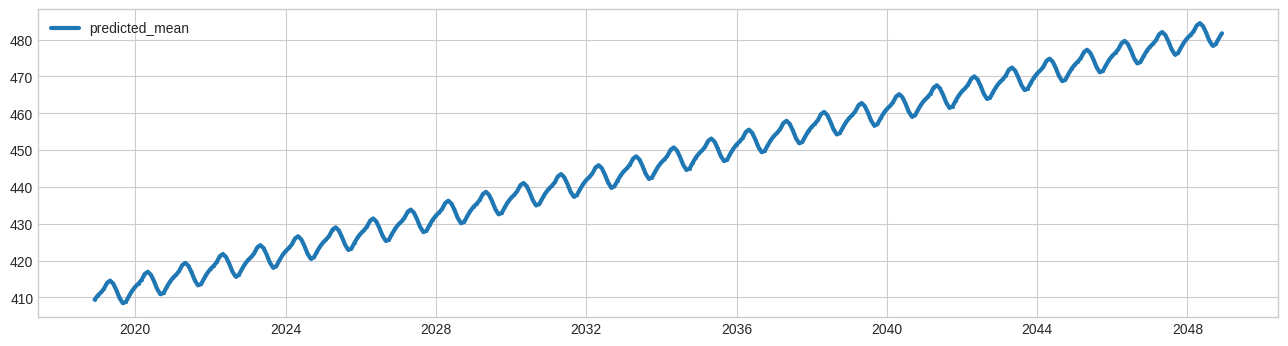

In [105]:
df_pred=pd.DataFrame(pred)
plot(df_pred, ts_linewidth=3)

In [73]:
res_forecast=predict.predicted_mean

In [78]:
res_forecast['2018-07-01']=2000

In [79]:
res_forecast

2017-01-01     405.641305
2017-02-01     406.503223
2017-03-01     407.472128
2017-04-01     409.110172
2017-05-01     409.714651
2017-06-01     408.879480
2017-07-01     407.122330
2017-08-01     404.981461
2017-09-01     403.608924
2017-10-01     403.945914
2017-11-01     405.557943
2017-12-01     406.970227
2018-01-01     408.086175
2018-02-01     408.924509
2018-03-01     409.886032
2018-04-01     411.521767
2018-05-01     412.125522
2018-06-01     411.290125
2018-07-01    2000.000000
Freq: MS, Name: predicted_mean, dtype: float64

In [48]:
df=df[:'2019-06-01'].resample('Q').sum()
df.tail()

,Y
Xm,
2018-06-30,4845.5
2018-09-30,6222.9
2018-12-31,7884.8
2019-03-31,6690.6
2019-06-30,3649.9


Обратите только внимание, что надо ограничить период таким образом, чтобы у нас формировались полные кварталы. В 2019 году у нас есть только два полных квартала. 

Чтобы сохранить результат достаточно выполнить внутренний метод `to_excel` и указать название файла. Пример ниже. 

In [47]:
res_forecast.to_excel('Result_forecast.xlsx')